In [1]:
from utils import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from collections import deque
import random

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [13]:
# stock configs
ticker = ['AAPL']
start_date = '2015-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.

In [14]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2268, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-04-01,28.007384,28.074699,27.621446,27.879486,162485600,0.0,0.0
1,2015-04-02,28.054503,28.173425,27.866022,28.119574,128880400,0.0,0.0
2,2015-04-06,27.928857,28.610979,27.897443,28.575077,148776000,0.0,0.0
3,2015-04-07,28.640143,28.747846,28.267670,28.274401,140049200,0.0,0.0
4,2015-04-08,28.238499,28.361910,28.041043,28.182404,149316800,0.0,0.0


In [15]:
count = int(np.ceil(len(data) * 0.1))
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0
signals['trend'] = data['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1

In [16]:
def buy_stock(real_movement, signal, initial_money=10000, max_buy=1, max_sell=1):
    """
    Function to simulate the buying and selling of stocks based on a trading signal.

    Parameters:
    - real_movement: The actual price movement of the stock in the real world.
    - signal: The trading signal indicating whether to buy (1) or sell (-1).
    - initial_money: The initial amount of money available for trading (default: 10000).
    - max_buy: The maximum quantity of shares to buy in a single transaction (default: 1).
    - max_sell: The maximum quantity of shares to sell in a single transaction (default: 1).

    Returns:
    - states_buy: A list of indices indicating the days on which a buy transaction occurred.
    - states_sell: A list of indices indicating the days on which a sell transaction occurred.
    - total_gains: The total gains achieved from the trading strategy.
    - invest: The percentage return on investment.
    """

    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        """
        Helper function to execute a buy transaction.

        Parameters:
        - i: The current index (day) of the trading simulation.
        - initial_money: The current amount of money available for trading.
        - current_inventory: The current number of shares held in the inventory.

        Returns:
        - initial_money: The updated amount of money after the buy transaction.
        - current_inventory: The updated number of shares in the inventory after the buy transaction.
        """
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(f"day {i}: total balances {initial_money:.2f}, not enough money to buy a unit price {real_movement[i]:.2f}")
        else:
            buy_units = min(shares, max_buy)
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(f"day {i}: buy {buy_units} units at price {real_movement[i]:.2f}, total balance {initial_money:.2f}")
            states_buy.append(i)
        return initial_money, current_inventory

    # Simulate the trading strategy
    for i in range(real_movement.shape[0] - int(0.025 * len(data))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(i, initial_money, current_inventory)
        elif state == -1:
            if current_inventory == 0:
                print(f"day {i}: cannot sell anything, inventory 0")
            else:
                sell_units = min(current_inventory, max_sell)
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                invest = 0
                if states_buy:
                    invest = ((real_movement[i] - real_movement[states_buy[-1]]) / real_movement[states_buy[-1]]) * 100
                print(f"day {i}, sell {sell_units} units at price {total_sell:.2f}, investment {invest:.2f}%, total balance {initial_money:.2f}")
                states_sell.append(i)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest


In [17]:
# Execute the trading strategy
states_buy, states_sell, total_gains, invest = buy_stock(data.Close, signals['signal'])

day 281: buy 1 units at price 20.77, total balance 9979.23
day 387, sell 1 units at price 27.13, investment 30.59%, total balance 10006.35
day 389: cannot sell anything, inventory 0
day 395: cannot sell anything, inventory 0
day 396: cannot sell anything, inventory 0
day 446: cannot sell anything, inventory 0
day 447: cannot sell anything, inventory 0
day 448: cannot sell anything, inventory 0
day 449: cannot sell anything, inventory 0
day 452: cannot sell anything, inventory 0
day 456: cannot sell anything, inventory 0
day 458: cannot sell anything, inventory 0
day 459: cannot sell anything, inventory 0
day 460: cannot sell anything, inventory 0
day 463: cannot sell anything, inventory 0
day 465: cannot sell anything, inventory 0
day 466: cannot sell anything, inventory 0
day 467: cannot sell anything, inventory 0
day 468: cannot sell anything, inventory 0
day 469: cannot sell anything, inventory 0
day 471: cannot sell anything, inventory 0
day 472: cannot sell anything, inventory 0
d

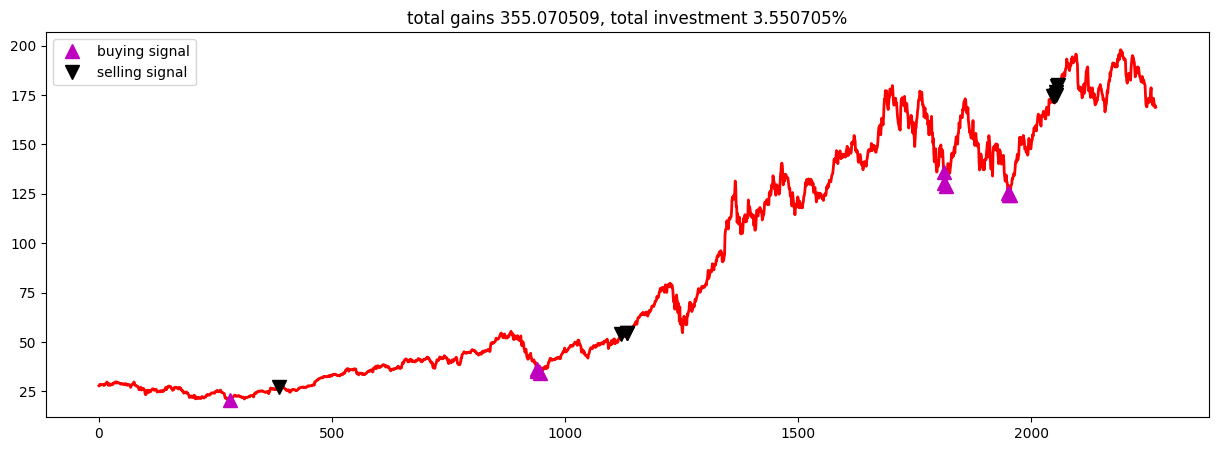

In [18]:
close = data['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()